## Canine GWAS Target Sample Selection

Steps:
    
- Merge reference and target datasets
- Filter to autosomes
- Run PCA on the merged dataset filtered to reference samples
- Investigate high loadings
- Potentially re-run PCA if SNPs need to be removed
- Project all target samples onto the reference PCA space
- Select target samples in the neighborhood of homogeneous labeled populations (in the reference set)

In [1]:
import hail as hl
import pandas as pd
import numpy as np
import plotnine as pn
import plotly.express as px
import plotly.graph_objects as go
import os.path as osp
from IPython.display import Image
from gwas_analysis import pca
%run ../../nb.py
%run paths.py
%run common.py
gab.register_timeop_magic(get_ipython(), 'hail')
hl.init()

ERROR:root:File `'utils.py'` not found.
Running on Apache Spark version 2.4.4
SparkUI available at http://d40dbc6dadcd:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.32-a5876a0a2853
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/organism/canine/hail-20200215-1159-0.2.32-a5876a0a2853.log


### Load Target and Reference Data

In [2]:
%%capture
hl.ReferenceGenome(**load_reference_genome(REF_GENOME_FILE))

In [3]:
mt_ref = hl.read_matrix_table(osp.join(WORK_DIR, REF_QC_03_FILE + '.mt'))
mt_ref = mt_ref.drop('pcs')
mt_ref = mt_ref.annotate_cols(source='ref')
mt_ref = mt_ref.key_cols_by('source', 's')
mt_ref.count()

(36332, 1350)

In [4]:
mt_tgt = hl.import_plink(
    *plink_files(ORGANISM_CANINE_TGT_DIR, PLINK_FILE_TGT),
    skip_invalid_loci=False,
    reference_genome='canine'
)
mt_tgt = mt_tgt.annotate_cols(**{c: hl.null(hl.tstr) for c in ['breed', 'breed_clade', 'breed_name']})
mt_tgt = mt_tgt.annotate_cols(source='tgt')
mt_tgt = mt_tgt.key_cols_by('source', 's')
mt_tgt.count()

2020-02-15 11:59:52 Hail: INFO: Found 4342 samples in fam file.
2020-02-15 11:59:52 Hail: INFO: Found 160727 variants in bim file.
2020-02-15 11:59:54 Hail: INFO: Coerced sorted dataset


(160727, 4342)

### Merge Datasets

In [5]:
# Resolve minor schema conflicts
def prep_ref(mt):
    mt = mt.drop('pcs')
    return mt.key_cols_by('source', 's')

def prep_tgt(mt):
    mt = mt.annotate_cols(**{c: hl.null(hl.tstr) for c in ['breed', 'breed_clade', 'breed_name']})
    return mt.key_cols_by('source', 's')
    
# Concatenate along sample axis, joining to only shared variants (by locus and allele)
mt = mt_ref.union_cols(mt_tgt, row_join_type='inner')

# After the merge, there should be as many variants left as there
# were originally in the reference dataset
assert mt.count()[0] == mt_ref.count()[0]

# Filter to autosomes (which means chrosome 1-38 for dogs)
mt = mt.filter_rows(mt.locus.in_autosome())
mt.count()

2020-02-15 11:59:55 Hail: INFO: Coerced sorted dataset
2020-02-15 11:59:56 Hail: INFO: Coerced sorted dataset


(36332, 5692)

### Raw PCA 

TODO: Explain details from in the context of this data [bigsnpr/how-to-PCA](https://privefl.github.io/bigsnpr/articles/how-to-PCA.html).

In [ ]:
pc_scores, pc_loadings = pca.utils.hwe_normalized_pca(mt_tgt)[1:]

In [89]:
def get_scores_fig(ht, pc1, pc2, color=None, symbol=None, **kwargs):
    lbl = (f'PC{pc1+1}', f'PC{pc2+1}')
    fields = {lbl[0]: ht.scores[pc1], lbl[1]: ht.scores[pc2]}
    if color:
        fields[color] = ht[color]
    if symbol:
        fields[symbol] = ht[symbol]
    df = ht.annotate(**fields).key_by().select(*list(fields.keys())).to_pandas()
    return px.scatter(df, x=lbl[0], y=lbl[1], color=color, symbol=symbol, **kwargs)

In [ ]:
fig = get_scores_fig(pc_scores)
fig.update_layout(title='Raw Target Data PCA')
Image(fig.to_image('png', width=800, height=500))

- TODO: Explain what a loadings plot is (mention x axis)
- TODO: Explain what peaks may indicate
- TODO: Explain how to contrast this with later loadings plots

In [ ]:
fig = pca.viz.get_loadings_fig(pca.viz.get_loadings_df(pc_loadings))
fig.update_layout(title='Raw Target Data PCA Loadings')
Image(fig.to_image('png', width=1200, height=600))

### QC PCA (Round 1)

In [6]:
def pca_fit_project(mt_ref, mt_tgt, n_pcs=10):
    pc_scores_ref, pc_loadings_ref = pca.utils.hwe_normalized_pca(mt_ref, n_pcs=n_pcs)[1:]
    pc_scores_tgt = pca.utils.pc_project(mt_tgt, pc_loadings_ref)
    return (pc_scores_ref, pc_scores_tgt), pc_loadings_ref

In [7]:
pc_scores, pc_loadings_ref = pca_fit_project(mt.filter_cols(mt.source=='ref'), mt.filter_cols(mt.source=='tgt'), n_pcs=10)
assert pc_scores[0].count() + pc_scores[1].count() == mt.count()[1]

2020-02-15 11:59:59 Hail: INFO: Coerced sorted dataset
2020-02-15 12:00:10 Hail: INFO: hwe_normalized_pca: running PCA using 36332 variants.
2020-02-15 12:00:11 Hail: INFO: Coerced sorted dataset
2020-02-15 12:00:22 Hail: INFO: pca: running PCA with 10 components...
2020-02-15 12:00:50 Hail: INFO: Coerced sorted dataset
2020-02-15 12:00:50 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2020-02-15 12:00:51 Hail: INFO: Coerced sorted dataset
2020-02-15 12:00:51 Hail: INFO: Coerced sorted dataset


In [57]:
def add_sample_info(ht, ht_info, fields=['breed', 'breed_name', 'breed_clade']):
    return ht.annotate(**{c: ht_info[ht.key][c] for c in fields})

2020-02-15 12:49:11 Hail: INFO: Coerced sorted dataset
2020-02-15 12:49:12 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-15 12:49:12 Hail: INFO: Coerced sorted dataset


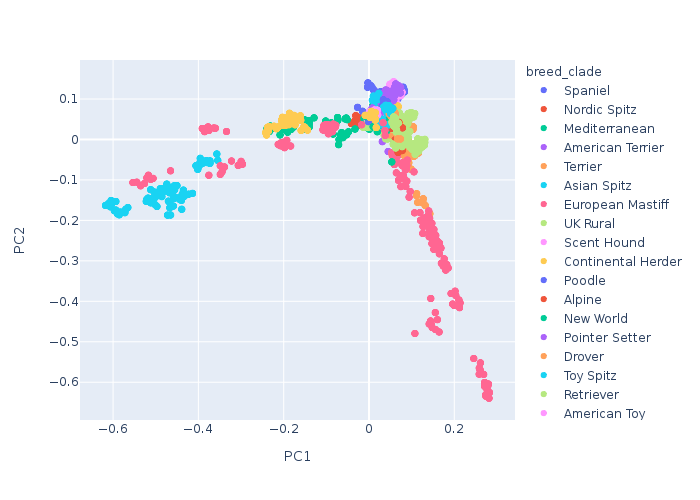

In [49]:
fig = get_scores_fig(add_sample_info(pc_scores[0], mt.filter_cols(mt.source=='ref').cols()), 0, 1, color='breed_clade')
Image(fig.to_image('png'), width=600, height=400)

#### Loadings

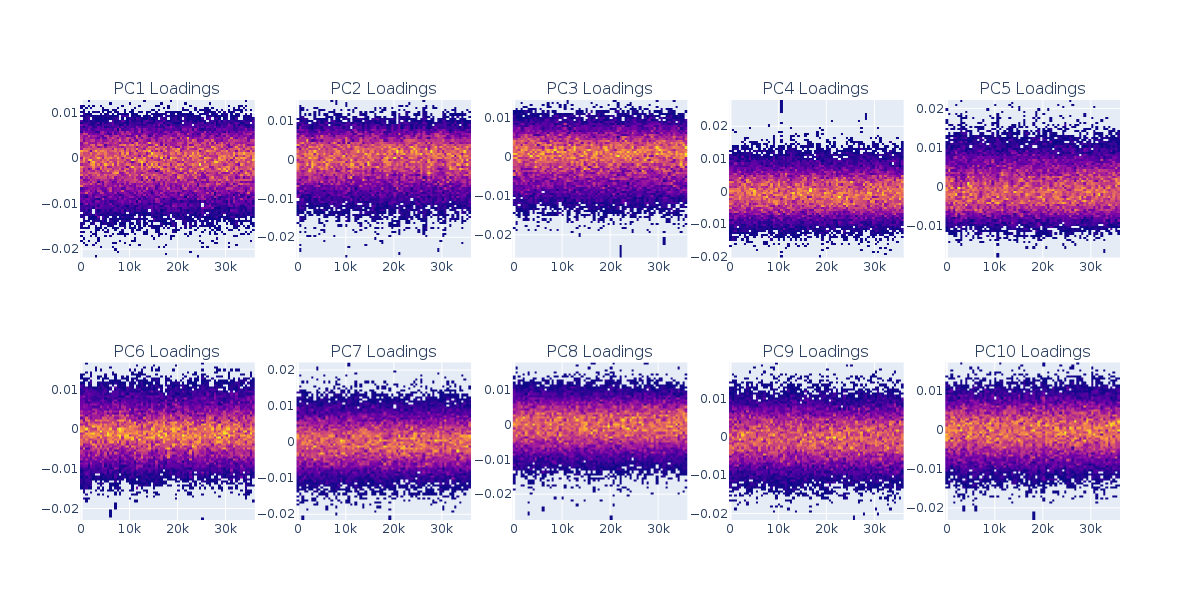

In [8]:
fig = pca.viz.get_loadings_fig(pca.viz.get_loadings_df(pc_loadings_ref))
Image(fig.to_image('png', width=1200, height=600))

We can see above that there are few suspicious peaks, for example in **PC3** and **PC4**.  The UKBB QC process involves identifying such large loadings and eliminating the associated SNPs.  There are no further details than that provided so in this analysis we will investigate them more closely before deciding what to do about them.

**NOTE**: LD will be used interchangeably with the concept of Pearson correlation in this analysis because Hail defines it that way (LD = Perason $r$ between vectors of alt allele counts).  This should not be confused with $D'$ ([Lewontin 1964](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1210557/)).

#### LD Assertion

First, we will check that our original dataset didn't have any variants in high LD w/ one another.  This should not be possible at this point in the pipeline (downstream from pruning), but it will be asserted anyhow.

In [12]:
def get_ld_matrix(mt, bp_window_size=1000000):
    bm = hl.ld_matrix(mt.GT.n_alt_alleles(), mt.locus, radius=bp_window_size)
    bm = bm.sparsify_triangle()
    return bm
ld = get_ld_matrix(mt.filter_cols(mt.source=='ref')).entries()
ld = ld.filter(ld.i != ld.j)
hist = ld.aggregate(hl.agg.hist(ld.entry, -1.01, 1.01, 128))
ld.describe()

2020-02-15 12:07:57 Hail: INFO: Coerced sorted dataset
2020-02-15 12:07:57 Hail: INFO: Coerced sorted dataset
2020-02-15 12:08:30 Hail: INFO: Wrote all 9 blocks of 36332 x 1350 matrix with block size 4096.
2020-02-15 12:08:31 Hail: INFO: Coerced sorted dataset


----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'i': int64 
    'j': int64 
    'entry': float64 
----------------------------------------
Key: ['i', 'j']
----------------------------------------


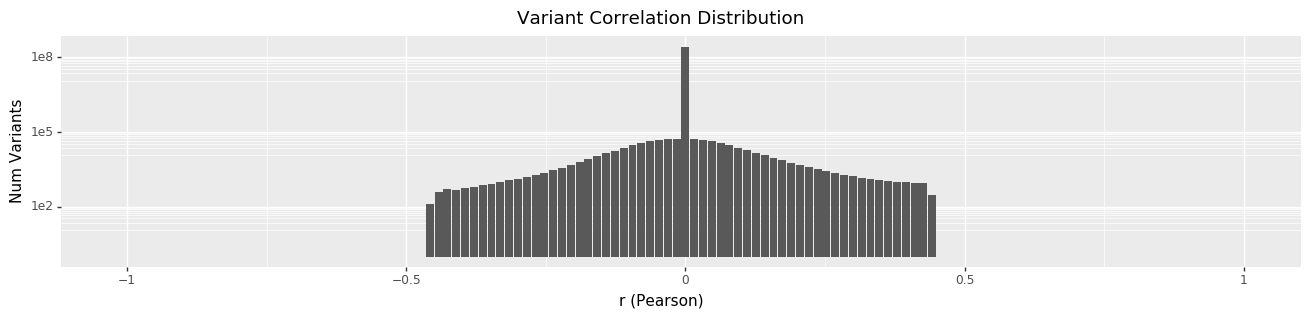

<ggplot: (8731986133525)>

In [15]:
(
    pn.ggplot(
        pd.DataFrame(dict(x=hist.bin_edges[:-1], y=hist.bin_freq))
        .assign(y=lambda df: df['y'] + 1),
        pn.aes(x='x', y='y')
    ) + 
    pn.geom_bar(stat='identity') + 
    pn.scale_y_log10() + 
    pn.labs(x='r (Pearson)', y='Num Variants', title='Variant Correlation Distribution') +
    pn.theme(figure_size=(16, 3))
)

In [100]:
max_r2 = ld.aggregate(hl.agg.max(ld.entry)**2)
assert max_r2 <= .2 # This was the ld_prune threshold used
max_r2

0.19999597651695786

No issues here -- any SNPs with high loadings in nearby genomic positions must reflect something about the population other than LD.

#### SNPs

The small number high loading values found above may be due to PCs that capture LD (which we don't want) or they may be due to valid components of population structure attributable to a small number of SNPs.  We can differentiate between the two by determining whether or not the SNPs with high loadings can be used to differentiate populations.  If they cannot, then we can be reasonably certain that they should be excluded from the remainder of this part of the QC process.

One way to better understand the distinction between LD and population structure is to imagine a scenario where a number of nearby SNPs each have nearly the same genotypes for all samples (i.e. they are independent of populations) and are highly correlated (i.e. in LD) with each other.  In this case, PCA will likely capture this axis of variation even though it has no relevance to what makes the populations different.  If we were to then use this axis as part of an analysis that is attempting to map populations to each other across datasets, that analysis would be flawed.  It would not have determined what samples are similar to others in a way that reflects ancestry.

The operations below will identify the SNPS with high loadings for **PC3** and **PC4** and show how genotypes for those SNPs related to population structure.

In [22]:
def extract_loading(ht, pc):
    """ Extract table containing loading vector for a single PC"""
    df = ht.transmute(loading=ht.loadings[pc]).to_pandas()
    # Order result by loading absolute value
    df = df.reindex(index=df.loading.abs().sort_values(ascending=False).index)
    return df
df_loading = extract_loading(pc_loadings_ref, 3)
df_loading.head()

2020-02-15 12:21:30 Hail: INFO: Coerced sorted dataset


,locus.contig,locus.position,alleles,pca_af,loading
10871,10,8483885,"[C, A]",0.335185,0.026707
28614,28,23197124,"[A, G]",0.271481,0.022269
27063,26,24104930,"[G, A]",0.283173,0.021683
21414,20,21966757,"[G, A]",0.424444,0.021540
10870,10,7504397,"[A, G]",0.501852,0.021353


In [35]:
# Show the top SNPs ordered by contig+position 
df_loading.head(10).sort_values(['locus.contig', 'locus.position'])

,locus.contig,locus.position,alleles,pca_af,loading
10870,10,7504397,"[A, G]",0.501852,0.021353
10871,10,8483885,"[C, A]",0.335185,0.026707
10873,10,8772534,"[A, G]",0.372774,-0.019883
12746,11,73113786,"[A, G]",0.292593,0.020211
19055,17,56295050,"[G, A]",0.182222,0.020152
21414,20,21966757,"[G, A]",0.424444,0.021540
27063,26,24104930,"[G, A]",0.283173,0.021683
28614,28,23197124,"[A, G]",0.271481,0.022269
31030,31,33058366,"[G, A]",0.288519,0.020143
8116,7,30192966,"[A, G]",0.262787,0.020480


In [85]:
# Summarize the genotype for a few select SNPs above
ht = mt.annotate_cols(
    snp_gt=hl.agg.sum(
        hl.if_else((hl.int(mt.locus.contig) == 10) & (mt.locus.position == 7504397), mt.GT.n_alt_alleles(), 0) + 
        hl.if_else((hl.int(mt.locus.contig) == 10) & (mt.locus.position == 8483885), mt.GT.n_alt_alleles(), 0) + 
        # Invert count because loading is negative
        hl.if_else((hl.int(mt.locus.contig) == 10) & (mt.locus.position == 8772534), 2-mt.GT.n_alt_alleles(), 0) +
        hl.if_else((hl.int(mt.locus.contig) == 11) & (mt.locus.position == 73113786), mt.GT.n_alt_alleles(), 0) +
        hl.if_else((hl.int(mt.locus.contig) == 20) & (mt.locus.position == 21966757), mt.GT.n_alt_alleles(), 0) 
    )
).cols()
ht.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    's': str 
    'fam_id': str 
    'pat_id': str 
    'mat_id': str 
    'is_female': bool 
    'is_case': bool 
    'breed': str 
    'breed_clade': str 
    'breed_name': str 
    'source': str 
    'snp_gt': int64 
----------------------------------------
Key: ['source', 's']
----------------------------------------


Show how the allele counts separate groups of samples:

2020-02-15 15:04:55 Hail: INFO: Coerced sorted dataset
2020-02-15 15:05:21 Hail: INFO: Coerced sorted dataset
2020-02-15 15:05:21 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-15 15:05:21 Hail: INFO: Coerced sorted dataset


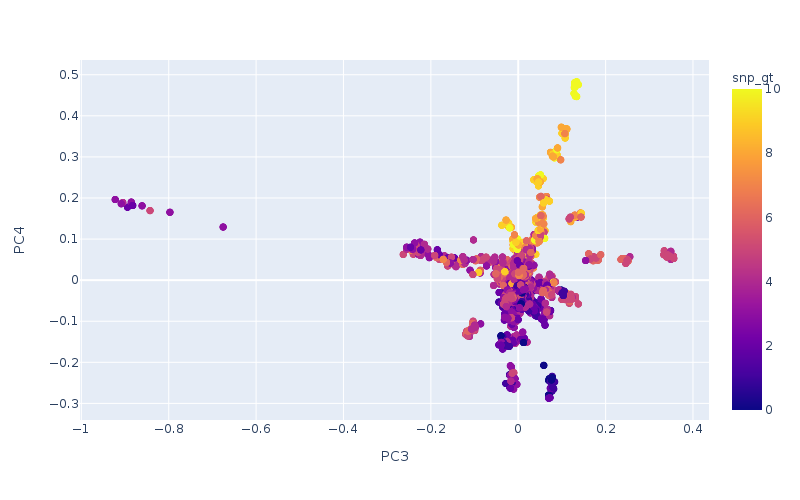

In [95]:
fig = get_scores_fig(
    add_sample_info(pc_scores[0], ht, fields=['breed', 'breed_name', 'breed_clade', 'snp_gt']), 
    2, 3, color='snp_gt')
Image(fig.to_image('png', width=800, height=500))

2020-02-15 15:09:29 Hail: INFO: Coerced sorted dataset
2020-02-15 15:09:29 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-15 15:09:29 Hail: INFO: Coerced sorted dataset


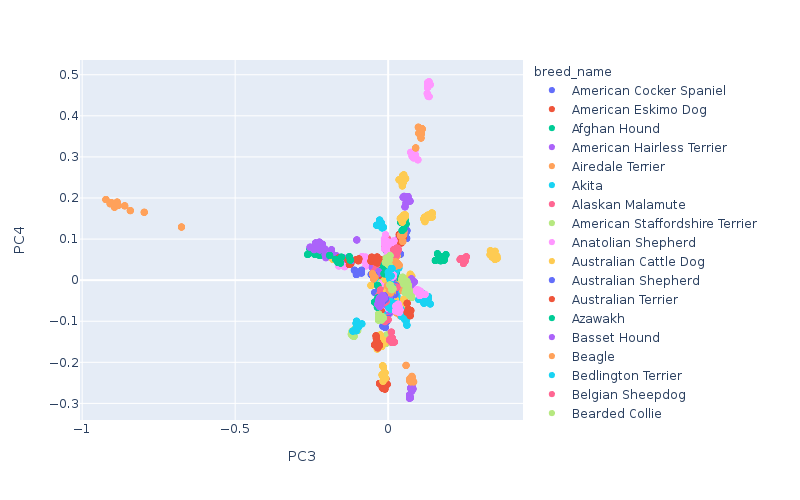

In [98]:
fig = get_scores_fig(
    add_sample_info(pc_scores[0], ht, fields=['breed', 'breed_name', 'breed_clade', 'snp_gt']), 
    2, 3, color='breed_name')
Image(fig.to_image('png', width=800, height=500))
#fig.show()

The breeds are: 
    - top: Collie, Shetland sheepdog, scottish deerhound, irish wolfound
    - left: Basenji
    - right: Siberian Husky, Alaskan Malamute, Greenland Sledge Dog


(dog db snp: https://bigd.big.ac.cn/dogsdv2/)

- TODO: Find a better way to visualize this all together
- TODO: Look for references on these SNPs
    - 10:8183593 is a locus with GWAS hit for body size in Parker 2016
- TODO: Regress the PC against SNPs?
- TODO: Look for methods for phylogenetic analysis based on SNPs
    - This may be useful: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3559126/#S4title
    - Also: Genome-wide SNP and haplotype analyses reveal a rich history underlying dog domestication
        - Supplemental Table 2. Eigenvalues and allele frequencies of the 20 SNPs with the highest magnitude loadings on PC1
            - Contains table of SNP loadings and how allele frequencies differ in dog vs wolf
        - Supplemental Figure 4. Genotypes of the 100 SNPs with highest loadings on PC1 (Supplemental Fig. 1)
            - Displays genotypes for all samples across variants associated with 100 top SNPs as heatmap
            - Try this!
- TODO: Related to methods regressing PCs against SNPs (pcadapt) to detect natural selection

### QC PCA (Round 2)

Depending on results from the above, this should be the final PCA for the reference data (possibly with a few less SNPs)

Add breed info to pca scores for reference data:

In [43]:
pc_scores_ref = pc_scores_ref.annotate(
    breed=mt_ref.cols()[pc_scores_ref.key].breed,
    breed_name=mt_ref.cols()[pc_scores_ref.key].breed_name,
    breed_clade=mt_ref.cols()[pc_scores_ref.key].breed_clade
)

Visualize:

In [79]:
df = pd.concat([
    pc_scores_ref.select(
        PC1=pc_scores_ref.scores[0], PC2=pc_scores_ref.scores[1], 
        breed=pc_scores_ref.breed,
        breed_name=pc_scores_ref.breed_name,
        breed_clade=pc_scores_ref.breed_clade
    ).to_pandas(),
    pc_scores_tgt.select(PC1=pc_scores_tgt.scores[0], PC2=pc_scores_tgt.scores[1]).to_pandas()
], sort=True)
df

2020-02-14 12:00:19 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-14 12:00:19 Hail: INFO: Coerced sorted dataset
2020-02-14 12:00:19 Hail: INFO: Coerced sorted dataset
2020-02-14 12:00:19 Hail: INFO: Coerced sorted dataset
2020-02-14 12:00:20 Hail: INFO: Coerced sorted dataset
2020-02-14 12:00:21 Hail: INFO: Coerced sorted dataset
2020-02-14 12:00:51 Hail: INFO: Coerced sorted dataset
2020-02-14 12:00:51 Hail: INFO: Coerced sorted dataset


,PC1,PC2,breed,breed_clade,breed_name,s,source
0,0.069806,0.127812,ACKR,Spaniel,American Cocker Spaniel,ACKR_09007,ref
1,0.056027,0.119430,ACKR,Spaniel,American Cocker Spaniel,ACKR_09030,ref
2,0.067480,0.118846,ACKR,Spaniel,American Cocker Spaniel,ACKR_09032,ref
3,0.059429,0.124184,ACKR,Spaniel,American Cocker Spaniel,ACKR_09110,ref
4,0.050433,0.134412,ACKR,Spaniel,American Cocker Spaniel,ACKR_09991,ref
...,...,...,...,...,...,...,...
4337,0.037342,0.099134,NaN,NaN,NaN,Wei_GT420,tgt
4338,0.044805,0.099170,NaN,NaN,NaN,Wei_GT421,tgt
4339,0.035003,0.111565,NaN,NaN,NaN,Wei_GT422,tgt
4340,0.039574,0.104670,NaN,NaN,NaN,Wei_GT423,tgt


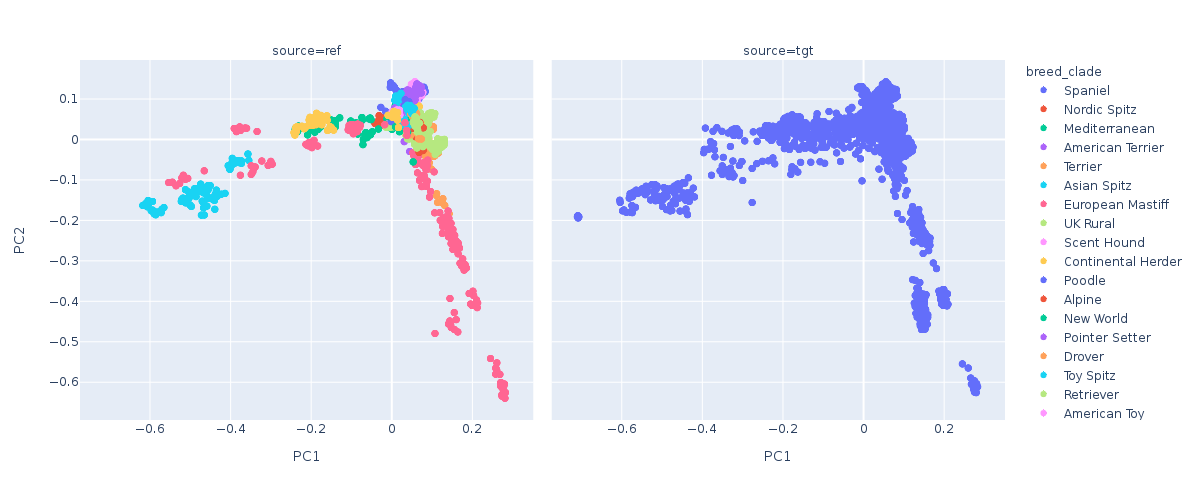

In [84]:
fig = px.scatter(
    df.fillna('NA'),
    x='PC1',
    y='PC2',
    color='breed_clade',
    facet_col='source',
    hover_name='breed'
)
#fig.show()
Image(fig.to_image('png', width=1200, height=500))